#Prepared by Tamal Acharya

#Core Features of SmolAgents

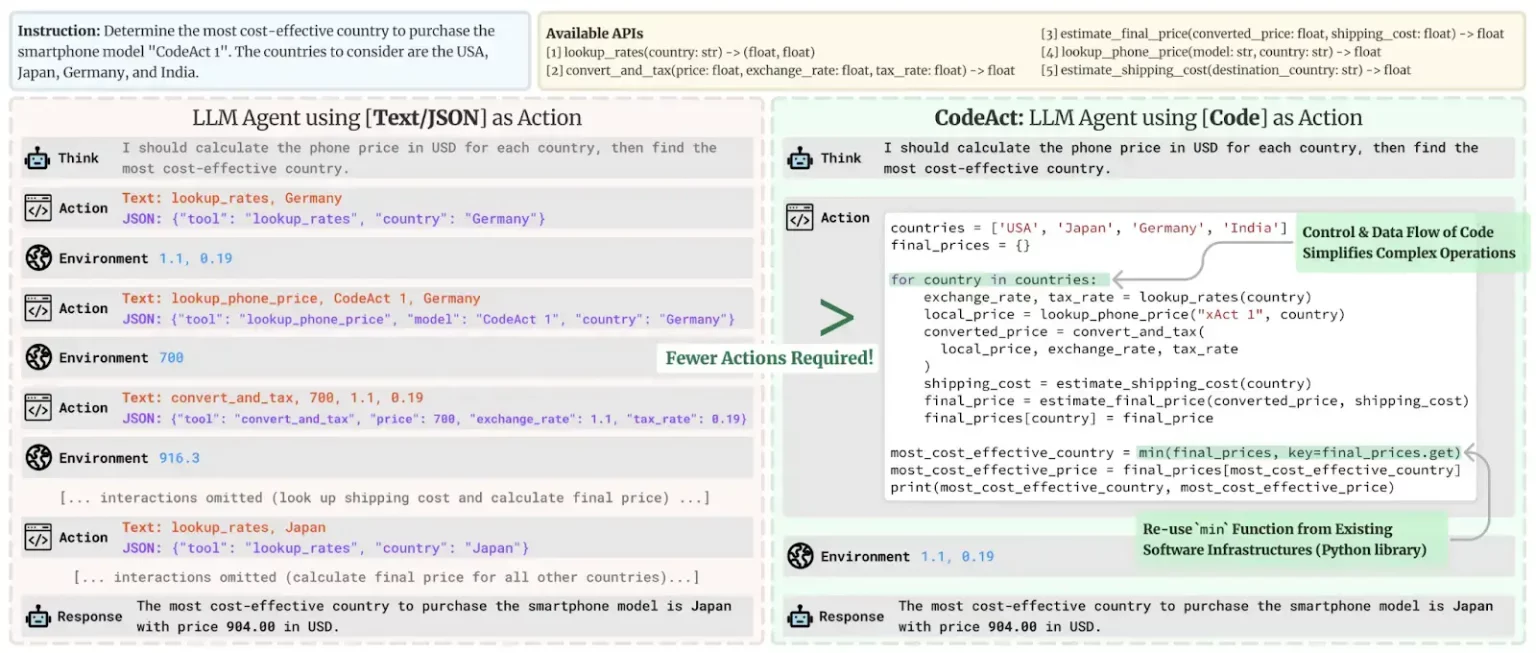

Source: Hugging Face

1. Code Agents:
SmolAgents specializes in “Code Agents” that can autonomously generate and execute code to perform user-defined tasks.
These agents can be securely executed in sandboxed environments like E2B, ensuring safe operation without unintended consequences.

2. ToolCallingAgents:
Traditional agents are capable of utilizing JSON or text-based actions to interact with the tool.  But the SmolAgent follows: “Thought: I should call tool ‘get_weather’. Action: get_weather(Paris).”) format.
These are ideal for scenarios requiring structured outputs and integration with various APIs or functions.

3. Extensive Integrations:
Supports various large language models (LLMs), including Hugging Face’s inference API, OpenAI, Anthropic, and more through LiteLLM.
Provides access to a shared tool repository on Hugging Face Hub, enhancing flexibility and adaptability.

4. Streamlined Architecture:
Provides robust building blocks for complex agent behaviours like tool calling and multi-step task execution.
Tailored for developers seeking a balance between simplicity and functionality.

#Components of SmolAgents

To create advanced agents, several elements work together:

1. LLM Core: Powers decision-making and actions of the agent.

2. Tool Repository: A predefined list of accessible tools the agent can use for task execution.

3. Parser: Processes the LLM’s outputs to extract actionable information.

4. System Prompt: Provides clear instructions and aligns with the parser to ensure consistent outputs.

5. Memory: Maintains context across iterations, crucial for multi-step agents.
Error Logging and Retry Mechanisms: Enhances system resilience and efficiency.

#Key Benefits of Combining SmolAgents and Agentic RAG:

1. Intelligence: SmolAgents adds reasoning, planning, and tool-calling capabilities to the RAG pipeline.

2. Adaptability: The agent can dynamically adjust its actions based on the retrieved data.

3. Efficiency: Reduces manual intervention by automating iterative processes.

4. Security: Ensures safe execution of external code and queries.

5. Scalability: Enables complex workflows that can be easily scaled or modified for different domains.

#Agentic RAG Hands-on with SmolAgents

Below image source: Analytics Vidhya

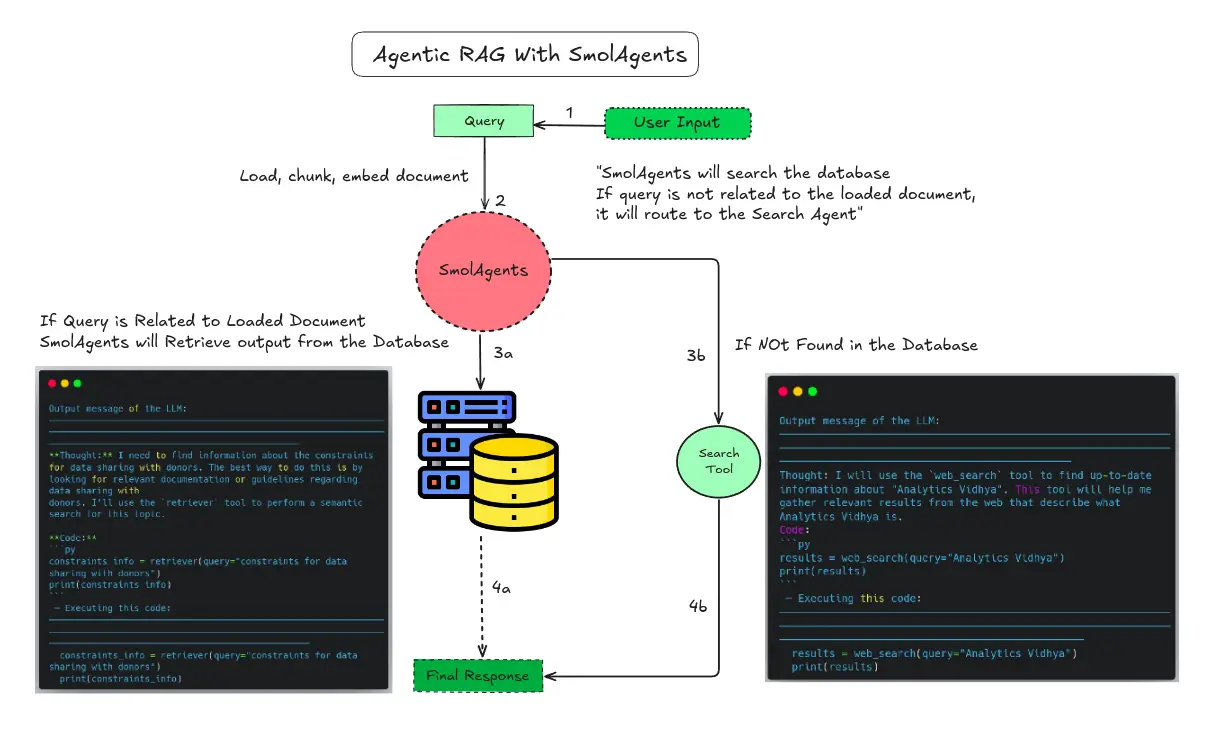

In [ ]:
#Required Python Packages
%pip install pypdf -q
%pip install faiss-cpu -q
!pip install -U langchain-community

In [ ]:
#Importing Required Libraries
from langchain.document_loaders import PyPDFLoader
from langchain.vectorstores import FAISS
# The other imports are likely correct and can remain as they are:
# from langchain_openai import OpenAIEmbeddings
# from langchain_openai.llms import OpenAI
# from langchain_openai.chat_models import ChatOpenAI
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [ ]:
#Loading and Splitting the PDF Document
loader = PyPDFLoader("/content/RESPONSIBLE DATA SHARING WITH DONORS.pdf")
pages = loader.load()

for page in pages:
   print(page.page_content)

In [ ]:
splitter = RecursiveCharacterTextSplitter(
   chunk_size=1000,
   chunk_overlap=200,
)
splitted_docs = splitter.split_documents(pages) # split_document accepts a list of documents

In [ ]:
print(len(splitted_docs))

In [ ]:
#First Chunk
print(splitted_docs[0])

In [ ]:
#Second Chunk
print(splitted_docs[1])

In [ ]:
print(splitted_docs[2])

In [ ]:
#Generating Embeddings
# from google.colab import userdata
# openai_api_key = userdata.get('OPENAI_API_KEY')
# # Set the API key for OpenAIEmbeddings
# embed_model = OpenAIEmbeddings(openai_api_key=openai_api_key)
# # Generate embeddings for the documents
# embeddings = embed_model.embed_documents([chunk.page_content for chunk in splitted_docs])
# print(f"Embeddings shape: {len(embeddings), len(embeddings[0])}")

# Generating Embeddings with Gemini
from google.colab import userdata
from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI

# Get your Gemini API key from Colab userdata
gemini_api_key = userdata.get('GEMINI_API_KEY')

# Set the API key for GeminiEmbeddings
embed_model = GoogleGenerativeAIEmbeddings(google_api_key=gemini_api_key, model="models/embedding-001")

# Initialize a Gemini model (replace with the specific model you need)
# This part is added in case you need a language model later in your notebook
# model = ChatGoogleGenerativeAI(model="gemini-pro", google_api_key=gemini_api_key)


# Generate embeddings for the documents
embeddings = embed_model.embed_documents([chunk.page_content for chunk in splitted_docs])
print(f"Embeddings shape: {len(embeddings), len(embeddings[0])}")

In [ ]:
vector_db = FAISS.from_documents(
   documents = splitted_docs,
   embedding = embed_model)

In [ ]:
similar_docs = vector_db.similarity_search("what is the objective for data sharing with donors?", k=5)
print(similar_docs[0].page_content)

In [ ]:
#SmolAgents
! pip -q install smolagents
! pip -q install litellm

In [ ]:
#Defining a Retriever Tool
from smolagents import Tool
class RetrieverTool(Tool):
   name = "retriever"
   description = "Uses semantic search to retrieve the parts of the documentation that could be most relevant to answer your query."
   inputs = {
       "query": {
           "type": "string",
           "description": "The query to perform. This should be semantically close to your target documents. Use the affirmative form rather than a question.",
       }
   }
   output_type = "string"
   def __init__(self, vector_db, **kwargs):  # Add vector_db as an argument
       super().__init__(**kwargs)
       self.vector_db = vector_db  # Store the vector database
   def forward(self, query: str) -> str:
       assert isinstance(query, str), "Your search query must be a string"
       docs = self.vector_db.similarity_search(query, k=4)  # Perform search here
       return "\nRetrieved documents:\n" + "".join(
           [
               f"\n\n===== Document {str(i)} =====\n" + doc.page_content
               for i, doc in enumerate(docs)
           ]
       )
retriever_tool = RetrieverTool(vector_db=vector_db)  # Pass vector_db during instantiation

In [ ]:
#Setting Up the Agent
# from smolagents import LiteLLMModel, DuckDuckGoSearchTool
# model = LiteLLMModel(model_id="gpt-4o", api_key = "your_api_key")
# search_tool = DuckDuckGoSearchTool()
# from smolagents import HfApiModel, CodeAgent
# agent = CodeAgent(
#    tools=[retriever_tool,search_tool], model=model, max_steps=6, verbose=True
# )

# Setting Up the Agent with Gemini
from smolagents import LiteLLMModel, DuckDuckGoSearchTool
from langchain_google_genai import ChatGoogleGenerativeAI
from google.colab import userdata
from smolagents import HfApiModel, CodeAgent

# Get your Gemini API key from Colab userdata
gemini_api_key = userdata.get('GEMINI_API_KEY')

# Initialize the Gemini model using LangChain's integration
# Replace "gemini-pro" with the specific Gemini model you want to use
model = ChatGoogleGenerativeAI(model="gemini-pro", google_api_key=gemini_api_key)

# Assuming DuckDuckGoSearchTool remains the same
search_tool = DuckDuckGoSearchTool()

# Assuming retriever_tool is defined elsewhere in your notebook

# Initialize the CodeAgent with the Gemini model and tools
agent = CodeAgent(
    tools=[retriever_tool, search_tool], model=model, max_steps=6, verbose=True
)


In [ ]:
agent.run("Tell me about Analytics Vidhya")

In [ ]:
agent_output = agent.run("what are the constraints for data sharing with donors?")
print("Final output:")
print(agent_output)

In [ ]:
#Final Output:
agent_output1 = agent.run("WHAT ARE THE OBJECTIVES FOR DATA SHARING WITH DONORS?")

Here we did the following:

1. Loads and processes a PDF document.

2. Splits the document into smaller chunks.

3. Generates embeddings for the chunks.

4. Creates a vector database for semantic search.

5. Defines a custom tool for retrieving relevant document chunks.

6. Sets up an agent (using SmolAgents) to answer queries using the retriever tool and a language model.